# Bike Rebalances EDA
Citibike does not provide data regarding bike rebalances, however, a bike that starts from a station where it did not end its previous trip it likely was either rebalanced or taken out of service. We will assume the former is the case for this preliminary exercise and consider ways to make this more robust in the future.

# Create Annual Rebalance Tables

In [ ]:
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# set import columns and preferred dtypes
trip_columns = [
    "starttime",
    "stoptime",
    "startstationid",
    "endstationid",
    "bikeid",
]
col_types = {
    "starttime": "datetime64",
    "stoptime": "datetime64",
    "startstationid": "category",
    "endstationid": "category",
    "bikeid": "category",
}

# create an dummy dataframe to offset when merging
offset = pd.DataFrame(
    {
        "starttime": pd.to_datetime("2010-09-01"),
        "startstationid": 0,
        "stoptime": pd.to_datetime("2010-09-01"),
        "endstationid": 0,
        "bikeid": 0,
    },
    index=[0],
)

for year in years:

    # load data from parquet
    print("starting...", year, "----------------------")
    print("loading...")
    trips = pd.read_parquet(
        "../data/tripdata_parquet/NY/" + str(year) + ".parquet",
        engine="pyarrow",
        columns=trip_columns,
    ).reset_index()
    trips.drop(trips.columns[0], axis=1, inplace=True)  # drop the dask index

    # convert dtypes (reduce memory)
    print("converting dtypes...")
    trips = trips.astype(col_types)

    # order trips sequentially by bike
    print("sorting...")
    trips = trips.sort_values(by=["bikeid", "starttime"])

    # offset rides1 (start stations) to track end station, rides 2 for start station
    print("creating trips1...")
    trips1 = (
        pd.concat([offset, trips])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid1"})
    )

    print("creating trips2...")
    trips2 = (
        pd.concat([trips, offset])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid2"})
    )

    # concat horizontally - a ride would start from the same endstation unless rebalanced
    print("concating trips1 and trips 2...")
    trips = pd.concat(
        [
            trips1[["bikeid1", "stoptime", "endstationid"]],
            trips2[["bikeid2", "starttime", "startstationid"]],
        ],
        axis=1,
    )

    # remove temp dataframes from memory
    del [trips1, trips2]
    gc.collect()

    # filter using rebalance criteria
    print("filtering....")
    trips = trips.loc[
        (trips.bikeid1 == trips.bikeid2) & (trips.startstationid != trips.endstationid)
    ]
    trips.drop(columns=["bikeid2"], inplace=True)

    # format and export
    print("formatting...")
    trips.rename(
        columns={
            "bikeid1": "bikeid",
            "stoptime": "prevtrip_stoptime",
            "endstationid": "prevtrip_endstationid",
        },
        inplace=True,
    )
    print("exporting to parquet...")
    rebal_filepath = "../data/rebalance_parquet/" + str(year) + "_rebalances.parquet"
    trips.to_parquet(rebal_filepath, engine="pyarrow")

print("complete!")

starting... 2013 ----------------------
loading...
converting dtypes...
sorting...
creating trips1...
creating trips2...
concating trips1 and trips 2...
filtering....
formatting...
exporting to parquet...
starting... 2014 ----------------------
loading...
converting dtypes...
sorting...
creating trips1...
creating trips2...
concating trips1 and trips 2...
filtering....
formatting...
exporting to parquet...
starting... 2015 ----------------------
loading...
converting dtypes...
sorting...
creating trips1...
creating trips2...
concating trips1 and trips 2...
filtering....
formatting...
exporting to parquet...
starting... 2016 ----------------------
loading...
converting dtypes...
sorting...
creating trips1...
creating trips2...
concating trips1 and trips 2...
filtering....
formatting...
exporting to parquet...
starting... 2017 ----------------------
loading...
converting dtypes...
sorting...
creating trips1...
creating trips2...
concating trips1 and trips 2...
filtering....
formatting...

# Create Master Rebalance Table

In [ ]:
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

rebal_dfs = []
rebal_files = [
    "../data/rebalance_parquet/" + str(y) + "_rebalances.parquet" for y in years
]

for rebal_file in rebal_files:
    print("appending..." + rebal_file)
    rebal_dfs.append(pd.read_parquet(rebal_file))

print("concating dfs...")
rebal = pd.concat(rebal_dfs)

print("exporting...")
rebal.to_parquet("../data/rebalance_parquet/all_rebalances.parquet", engine="pyarrow")
print("complete!")

appending...data/rebalance_parquet/2013_rebalances.parquet
appending...data/rebalance_parquet/2014_rebalances.parquet
appending...data/rebalance_parquet/2015_rebalances.parquet
appending...data/rebalance_parquet/2016_rebalances.parquet
appending...data/rebalance_parquet/2017_rebalances.parquet
appending...data/rebalance_parquet/2018_rebalances.parquet
appending...data/rebalance_parquet/2019_rebalances.parquet
appending...data/rebalance_parquet/2020_rebalances.parquet
appending...data/rebalance_parquet/2021_rebalances.parquet
concating dfs...
exporting...
complete!


# Create Featured Rebalance Table
Merge w/ stations data to include features like boro and elevation for EDA

In [ ]:
# load dataframes
stations = pd.read_parquet("../data/stations/stations.parquet")
rebal = pd.read_parquet("../data/rebalance_parquet/all_rebalances.parquet")

# merge startstation features
col_rename = {
    "stationid": "startstationid",
    "stationname": "startstationname",
    "capacity": "startcapacity",
    "neighbourhood": "startneighborhood",
    "boro": "startboro",
    "elevation_ft": "startelevation_ft",
}
stations.rename(columns=col_rename, inplace=True)
stations.drop(columns=(["latitude", "longitude", "zipcode"]), inplace=True)
rebal = rebal.merge(stations, how="left", on="startstationid")

# merge prevtrip_endstation features
col_rename = {
    "stationid": "prevtrip_endstationid",
    "stationname": "prevtrip_endstationname",
    "capacity": "prevtrip_capacity",
    "neighbourhood": "prevtrip_neighborhood",
    "boro": "prevtrip_boro",
    "elevation_ft": "prevtrip_elevation_ft",
}
stations = pd.read_parquet("../data/stations/stations.parquet")
stations.rename(columns=col_rename, inplace=True)
stations.drop(columns=(["latitude", "longitude", "zipcode"]), inplace=True)
rebal = rebal.merge(stations, how="left", on="prevtrip_endstationid")

rebal.to_parquet(
    "../data/rebalance_parquet/all_rebalances_features.parquet", engine="pyarrow"
)

# Rebal EDA
Assumptions
- Because we cannot know exact rebalance date if there is a gap between prevtrip_stoptime and starttime, we will assume the bike was rebalanced on starttime date (what is the latest possible timing for a rebalance to have occurred)

## Load Data

In [ ]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
%matplotlib inline

In [ ]:
rebal = pd.read_parquet("../data/rebalance_parquet/all_rebalances_features.parquet")

col_types = {
    "bikeid": "category",
    "prevtrip_stoptime": "datetime64",
    "prevtrip_endstationid": "category",
    "starttime": "datetime64",
    "startstationid": "category",
    "startstationname": "category",
    "startcapacity": "category",
    "startneighborhood": "category",
    "startboro": "category",
    "startelevation_ft": "float16",
    "prevtrip_endstationname": "category",
    "prevtrip_capacity": "category",
    "prevtrip_neighborhood": "category",
    "prevtrip_boro": "category",
    "prevtrip_elevation_ft": "float16",
}

rebal = rebal.astype(col_types)

In [ ]:
rebal.head()

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft
0,14529,2013-06-05 17:44:51,523.0,2013-06-05 18:32:40,475.0,E 16 St & Irving Pl,79.0,Union Square,Manhattan,36.09375,W 38 St & 8 Ave,NaN,Garment District,Manhattan,37.281250
1,14529,2013-06-05 18:59:44,284.0,2013-06-09 11:52:08,368.0,Carmine St & 6 Ave,47.0,West Village,Manhattan,16.90625,Greenwich Ave & 8 Ave,51.0,West Village,Manhattan,23.015625
2,14529,2013-06-09 11:57:47,229.0,2013-06-10 08:08:38,362.0,Broadway & W 37 St,57.0,Garment District,Manhattan,50.75000,Great Jones St,23.0,NoHo,Manhattan,41.562500
3,14529,2013-06-11 16:01:17,469.0,2013-06-12 11:40:59,293.0,Lafayette St & E 8 St,91.0,East Village,Manhattan,40.25000,Broadway & W 53 St,57.0,Theater District,Manhattan,70.125000
4,14529,2013-06-12 23:13:58,2003.0,2013-06-13 08:51:04,450.0,W 49 St & 8 Ave,67.0,Theater District,Manhattan,53.00000,1 Ave & E 18 St,54.0,Manhattan Community Board 6,Manhattan,16.765625


## Create Features

In [ ]:
# date/time features
rebal["rebal_dow"] = pd.DatetimeIndex(rebal["starttime"]).dayofweek
rebal["rebal_dom"] = pd.DatetimeIndex(rebal["starttime"]).day
rebal["rebal_week"] = pd.DatetimeIndex(rebal["starttime"]).week
rebal["rebal_month"] = pd.DatetimeIndex(rebal["starttime"]).month
rebal["rebal_year"] = pd.DatetimeIndex(rebal["starttime"]).year

# elevation features
rebal["rebal_elev_change"] = rebal.startelevation_ft - rebal.prevtrip_elevation_ft
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
rebal["startelevation_bin"] = pd.cut(rebal.startelevation_ft, bins=bins)
rebal["prevtrip_elevation_bin"] = pd.cut(rebal.prevtrip_elevation_ft, bins=bins)

/tmp/ipykernel_2651/4059520422.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  rebal['rebal_week'] = pd.DatetimeIndex(rebal['starttime']).week


In [ ]:
rebal.head()

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft,rebal_dow,rebal_dom,rebal_week,rebal_month,rebal_year,rebal_elev,startelevation_bin,prevtrip_elevation_bin
0,14529,2013-06-05 17:44:51,523.0,2013-06-05 18:32:40,475.0,E 16 St & Irving Pl,79.0,Union Square,Manhattan,36.09375,W 38 St & 8 Ave,NaN,Garment District,Manhattan,37.281250,2,5,23,6,2013,-1.187500,"(25, 50]","(25, 50]"
1,14529,2013-06-05 18:59:44,284.0,2013-06-09 11:52:08,368.0,Carmine St & 6 Ave,47.0,West Village,Manhattan,16.90625,Greenwich Ave & 8 Ave,51.0,West Village,Manhattan,23.015625,6,9,23,6,2013,-6.109375,"(0, 25]","(0, 25]"
2,14529,2013-06-09 11:57:47,229.0,2013-06-10 08:08:38,362.0,Broadway & W 37 St,57.0,Garment District,Manhattan,50.75000,Great Jones St,23.0,NoHo,Manhattan,41.562500,0,10,24,6,2013,9.187500,"(50, 75]","(25, 50]"
3,14529,2013-06-11 16:01:17,469.0,2013-06-12 11:40:59,293.0,Lafayette St & E 8 St,91.0,East Village,Manhattan,40.25000,Broadway & W 53 St,57.0,Theater District,Manhattan,70.125000,2,12,24,6,2013,-29.875000,"(25, 50]","(50, 75]"
4,14529,2013-06-12 23:13:58,2003.0,2013-06-13 08:51:04,450.0,W 49 St & 8 Ave,67.0,Theater District,Manhattan,53.00000,1 Ave & E 18 St,54.0,Manhattan Community Board 6,Manhattan,16.765625,3,13,24,6,2013,36.250000,"(50, 75]","(0, 25]"


## Rebalance Counts

### Unique Bikes Rebalanced

In [ ]:
# 32391 unique bikes rebalanced in total
rebal.bikeid.nunique()

32391

<AxesSubplot:title={'center':'Unique Bikes Rebalanced Per Year'}, xlabel='rebal_year'>

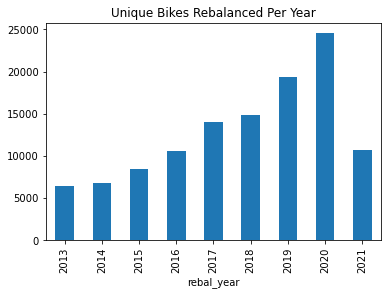

In [ ]:
# unique bikes rebalanced per year
rebal.groupby("rebal_year")["bikeid"].nunique().plot.bar(
    title="Unique Bikes Rebalanced Per Year"
)

### Total Bikes Rebalanced
- number of rebalances dropped sharply in 2018
  - number of unique bikes rebalanced close to 2017, but climbed sharply in 2019 and again in 2020
  - evidence of rebal rewards program?
- there is obvious seasonality in bike rebalances (months,days)
  -  likely follows trend in rides demand - to verify

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


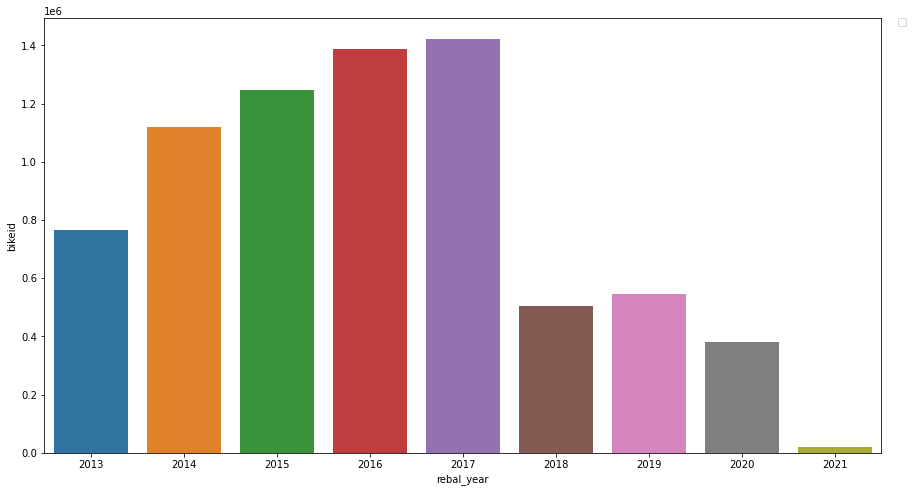

In [ ]:
# rebalances per year
g = rebal.groupby(["rebal_year"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_year, y=g.bikeid)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

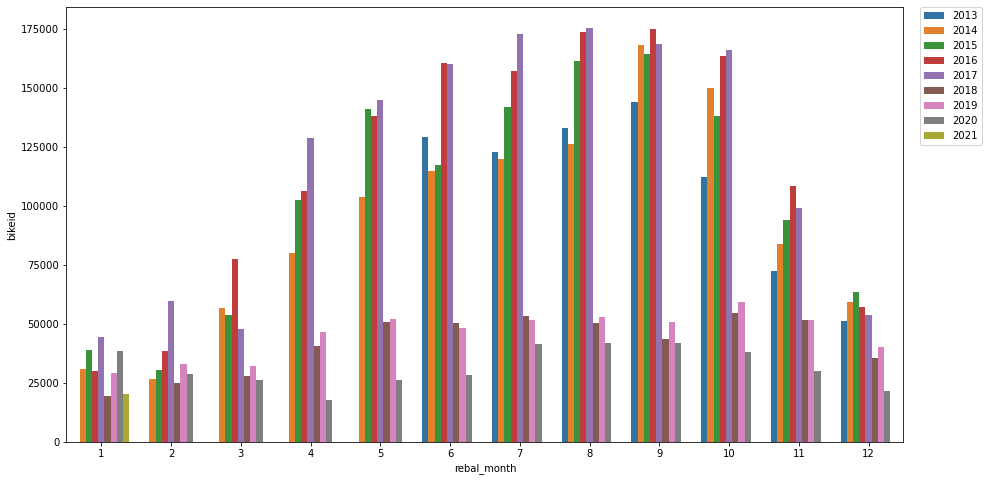

In [ ]:
# rebalances per month/year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_month, y=g.bikeid, hue=g.rebal_year)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

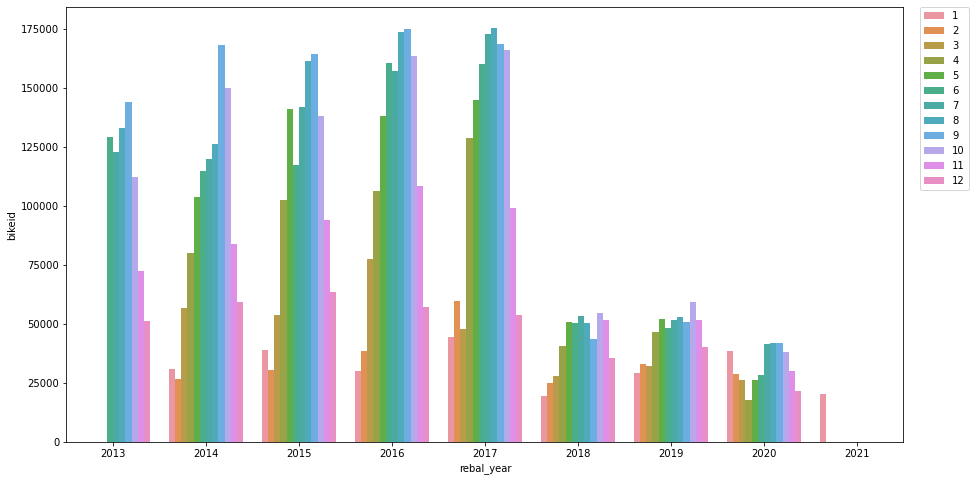

In [ ]:
# rebalances per month/year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_year, y=g.bikeid, hue=g.rebal_month)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

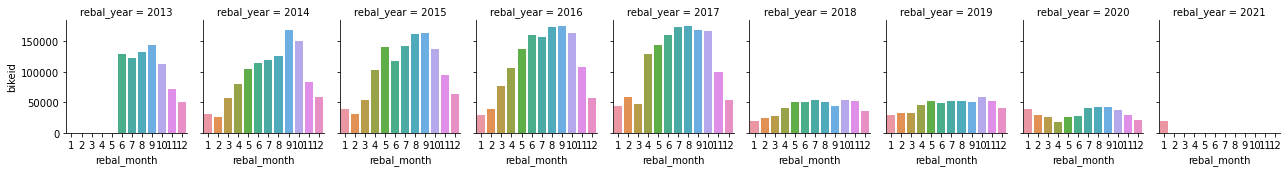

In [ ]:
# rebalances by month faceted by year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_month",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

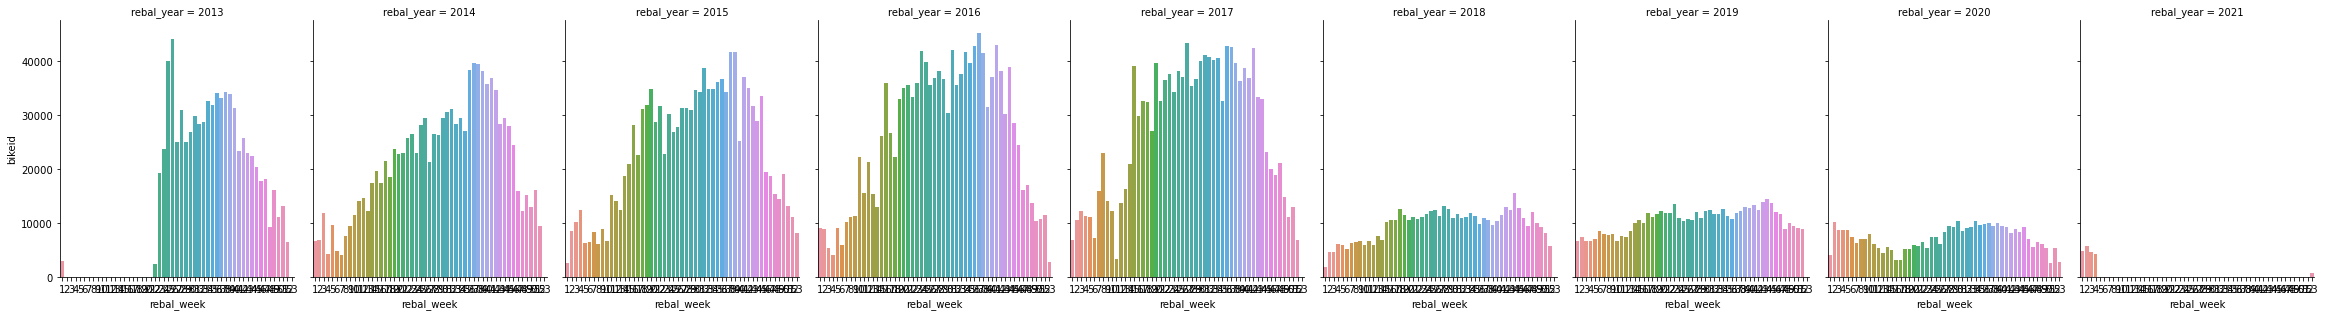

In [ ]:
# rebalances by week faceted by year
g = rebal.groupby(["rebal_year", "rebal_week"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_week",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
)

<AxesSubplot:xlabel='rebal_dow', ylabel='bikeid'>

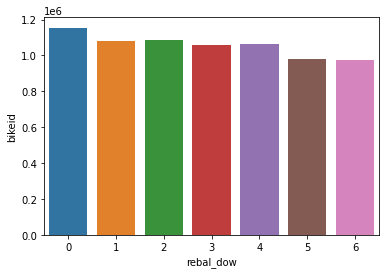

In [ ]:
# rebalances by DoW overall
g = rebal.groupby(["rebal_dow"])[["bikeid"]].count().reset_index()
sns.barplot(x="rebal_dow", y="bikeid", data=g)

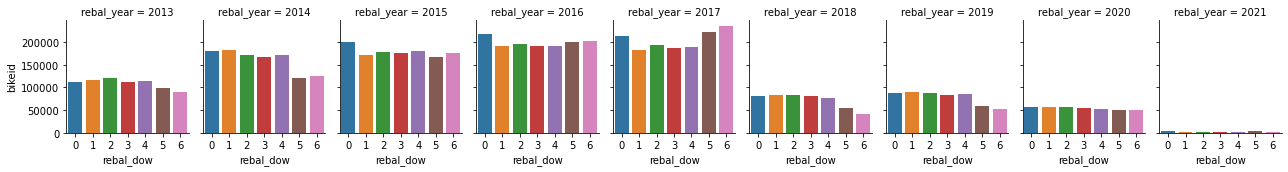

In [ ]:
# rebalances by DoW faceted by year
g = rebal.groupby(["rebal_year", "rebal_dow"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

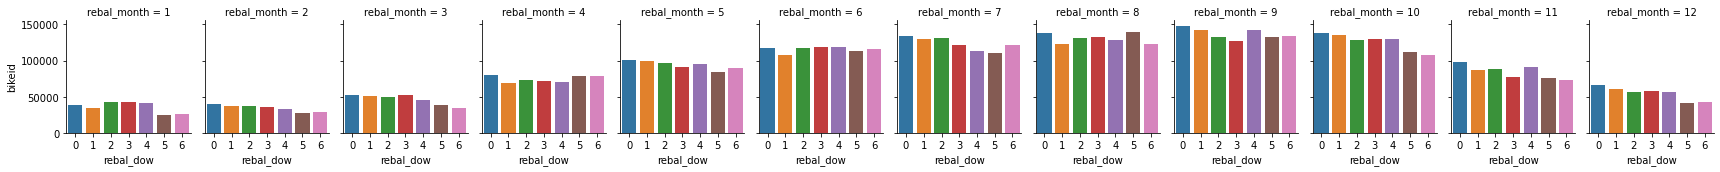

In [ ]:
# rebalances by DoW faceted by year
g = rebal.groupby(["rebal_month", "rebal_dow"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    col="rebal_month",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

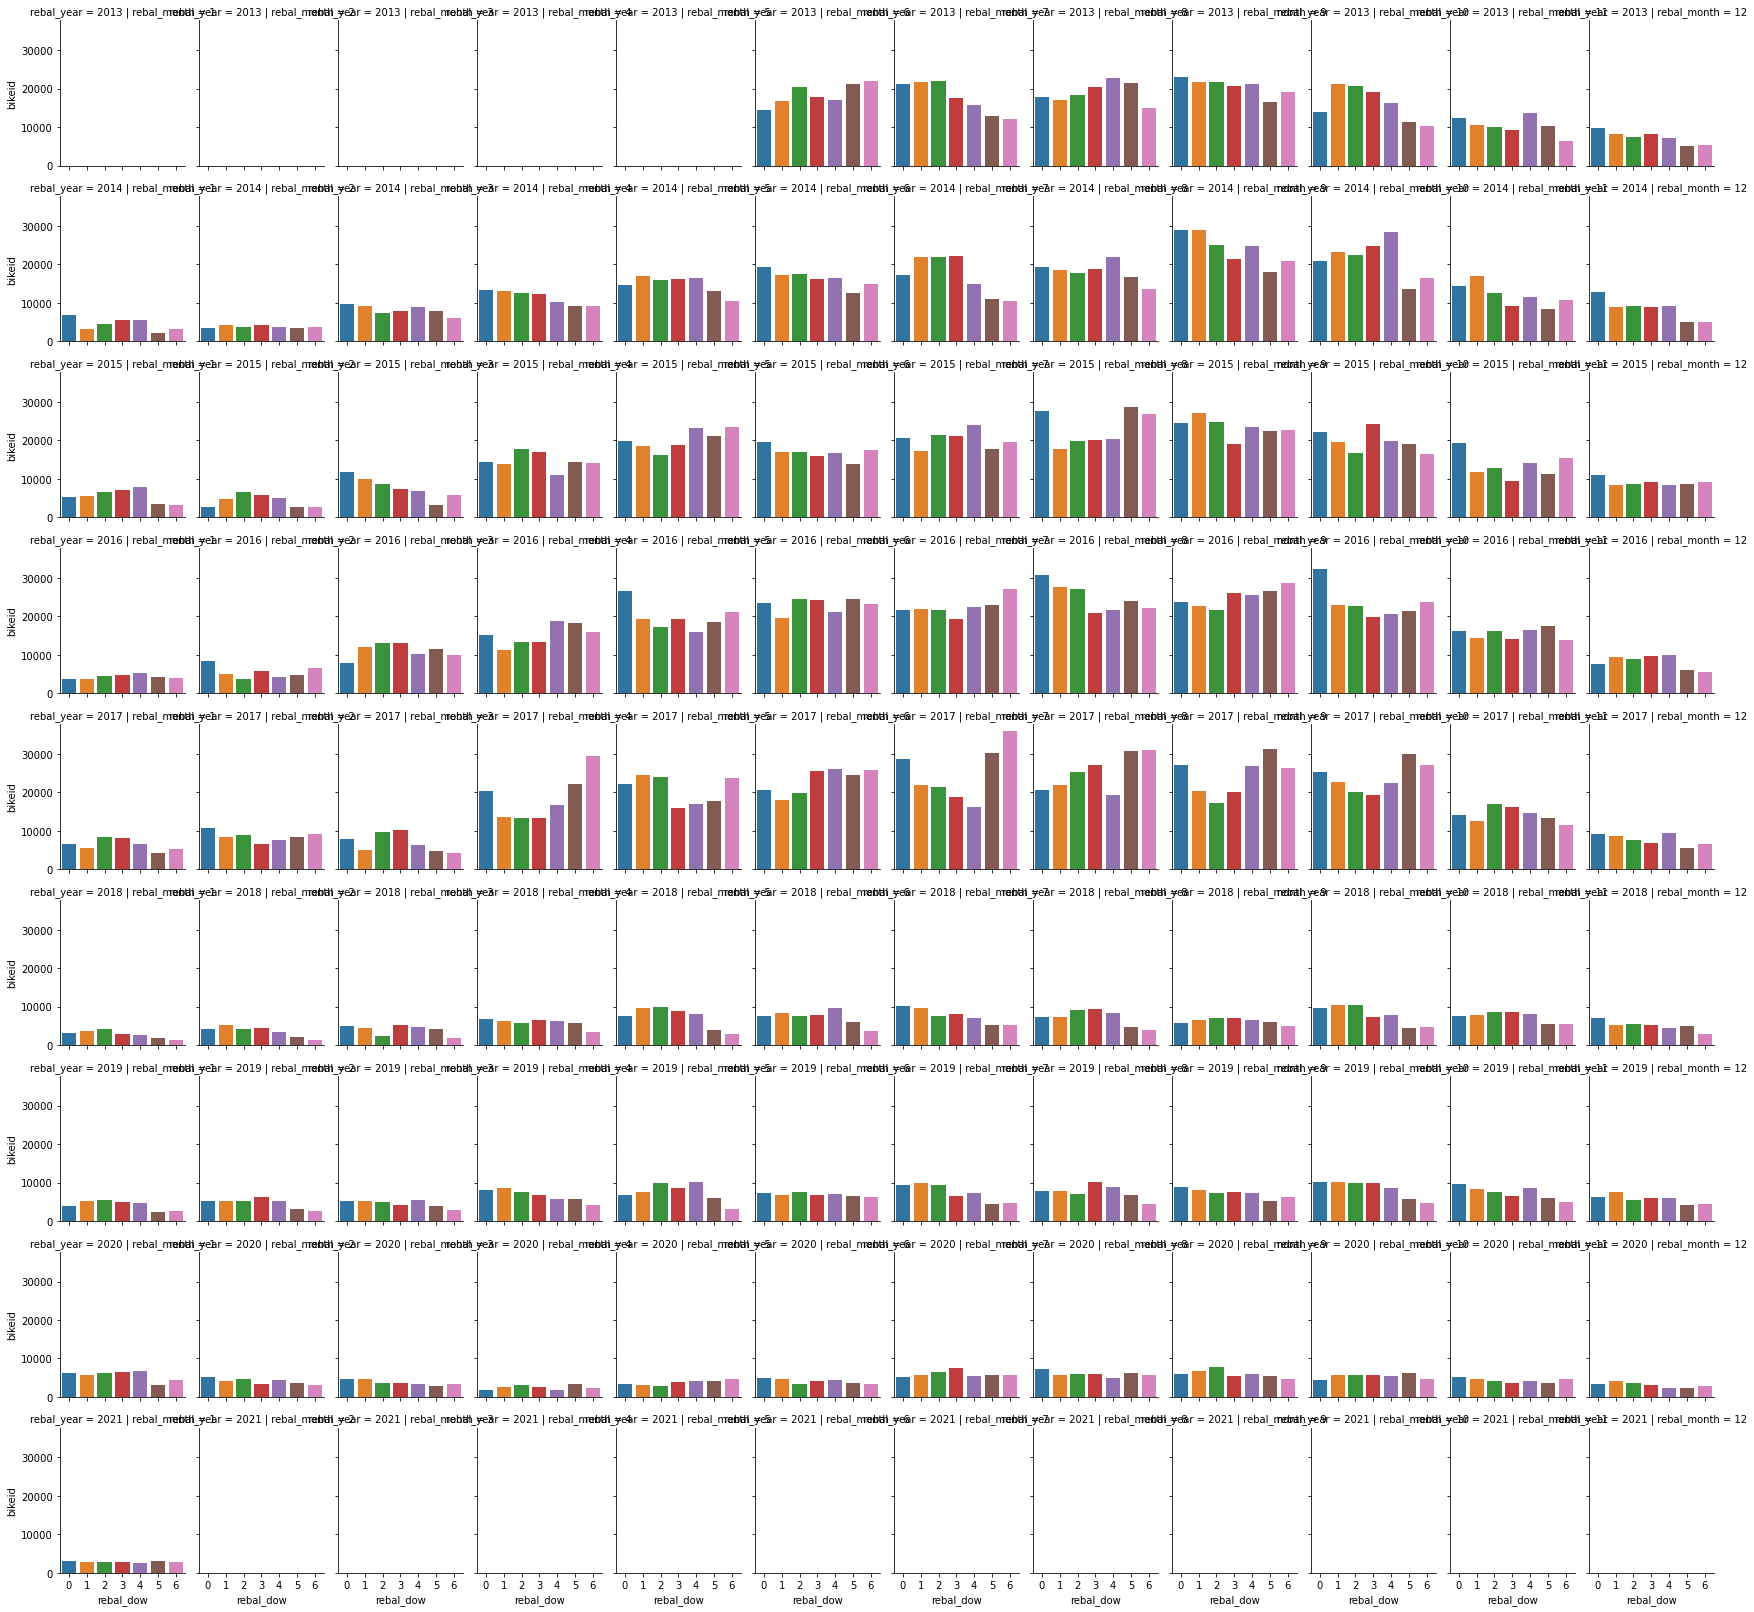

In [ ]:
# rebalances by DoW faceted by month and year
g = (
    rebal.groupby(["rebal_year", "rebal_month", "rebal_dow"])[["bikeid"]]
    .count()
    .reset_index()
)
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    row="rebal_year",
    col="rebal_month",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

## Elevation
New feature -  difference between station elevations
- rebal['rebal_elev'] = rebal.startelevation_ft - rebal.prevtrip_elevation_ft
Rebalanced To & From (elevantion counts)
- there are more rebalances from lower elevations to higher elevations
- how much do we care about faceting this

<AxesSubplot:xlabel='rebal_elev', ylabel='Count'>

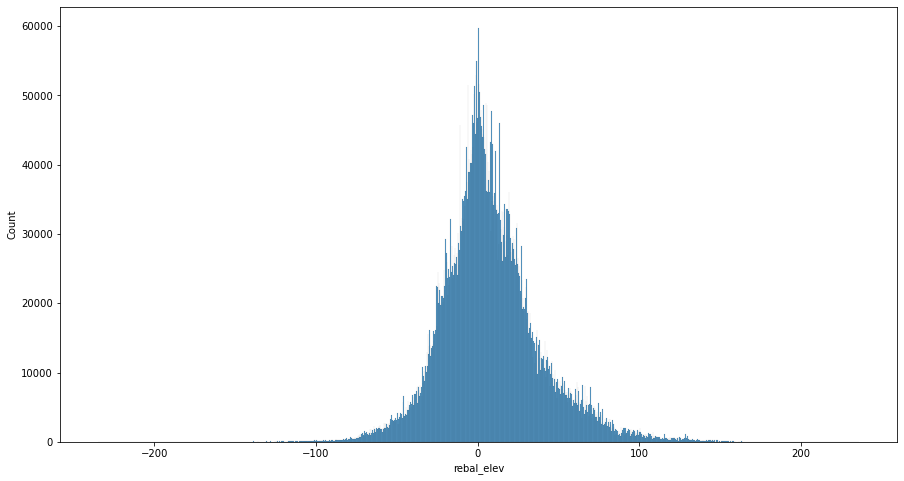

In [ ]:
# change in elevation for a given rebalance - overall
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal, x="rebal_elev_change")

<AxesSubplot:xlabel='rebal_elev', ylabel='Count'>

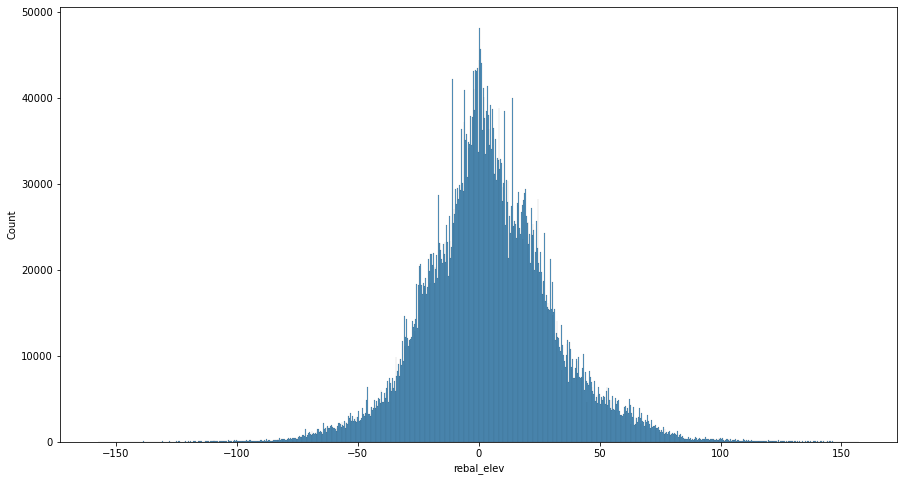

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal.loc[rebal.rebal_year < 2018], x="rebal_elev_change")

<AxesSubplot:xlabel='rebal_elev', ylabel='Count'>

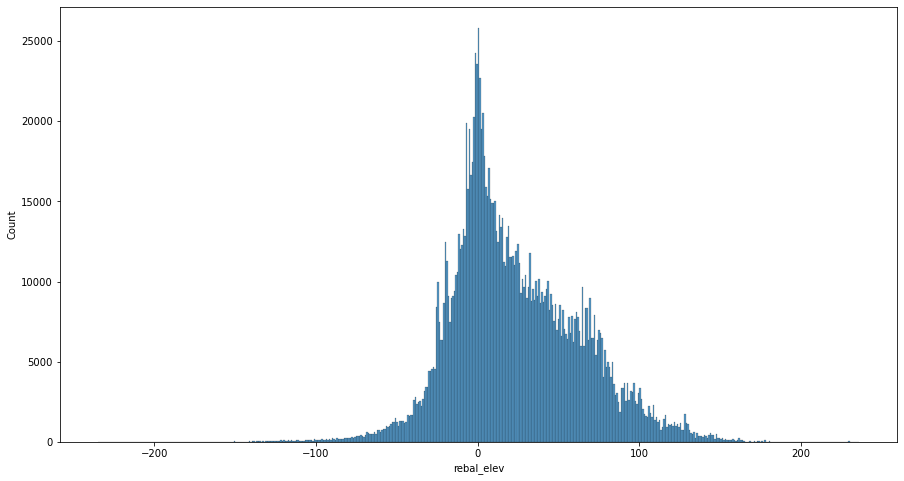

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal.loc[rebal.rebal_year >= 2018], x="rebal_elev_change")

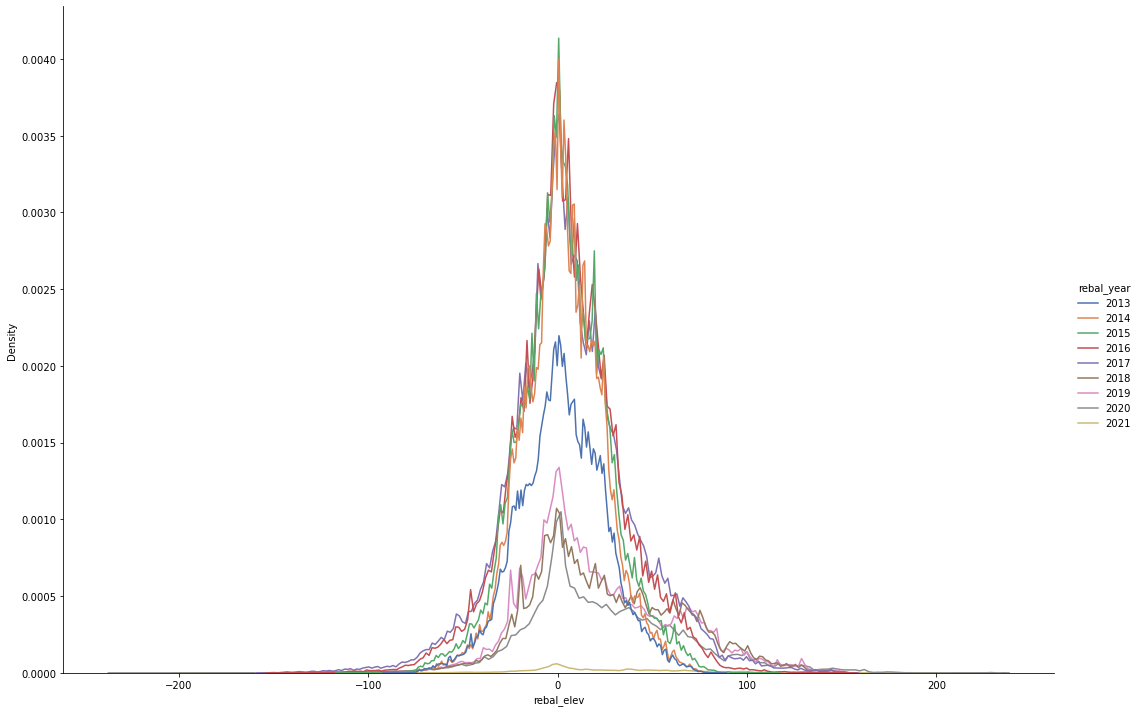

In [ ]:
sns.displot(
    data=rebal,
    x="rebal_elev_change",
    kind="kde",
    hue="rebal_year",
    bw_adjust=0.25,
    height=10,
    aspect=1.5,
    palette="deep",
)

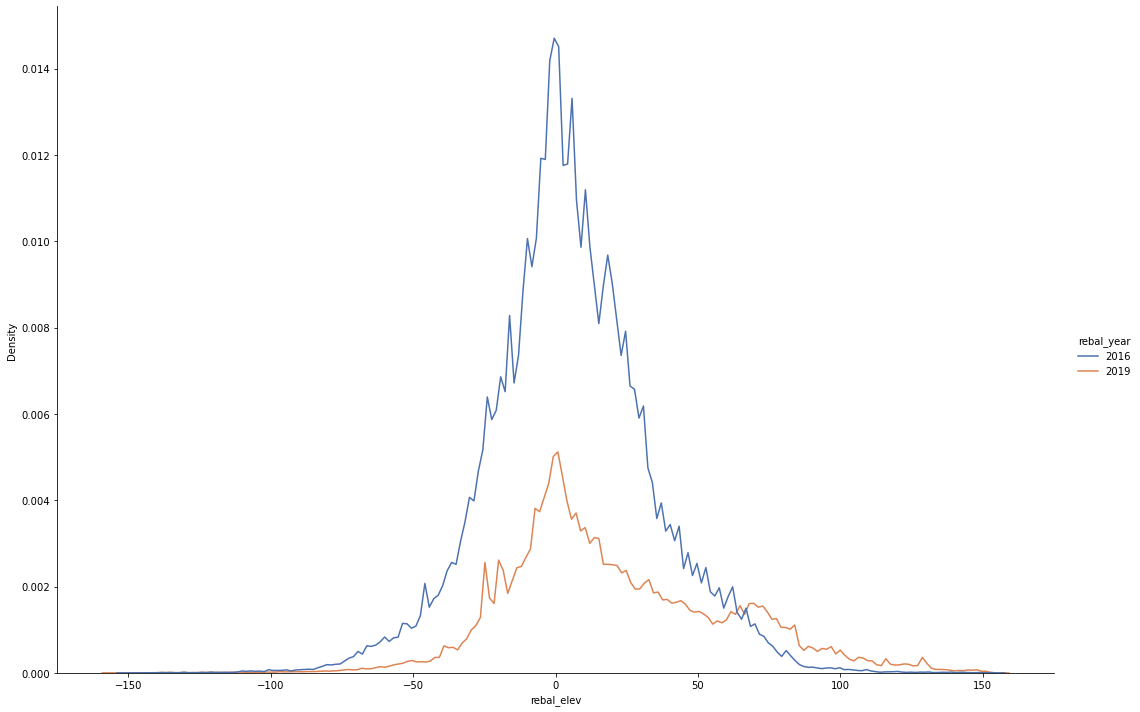

In [ ]:
sns.displot(
    data=rebal.loc[(rebal.rebal_year == 2016) | (rebal.rebal_year == 2019)],
    x="rebal_elev_change",
    kind="kde",
    hue="rebal_year",
    bw_adjust=0.25,
    height=10,
    aspect=1.5,
    palette="deep",
)

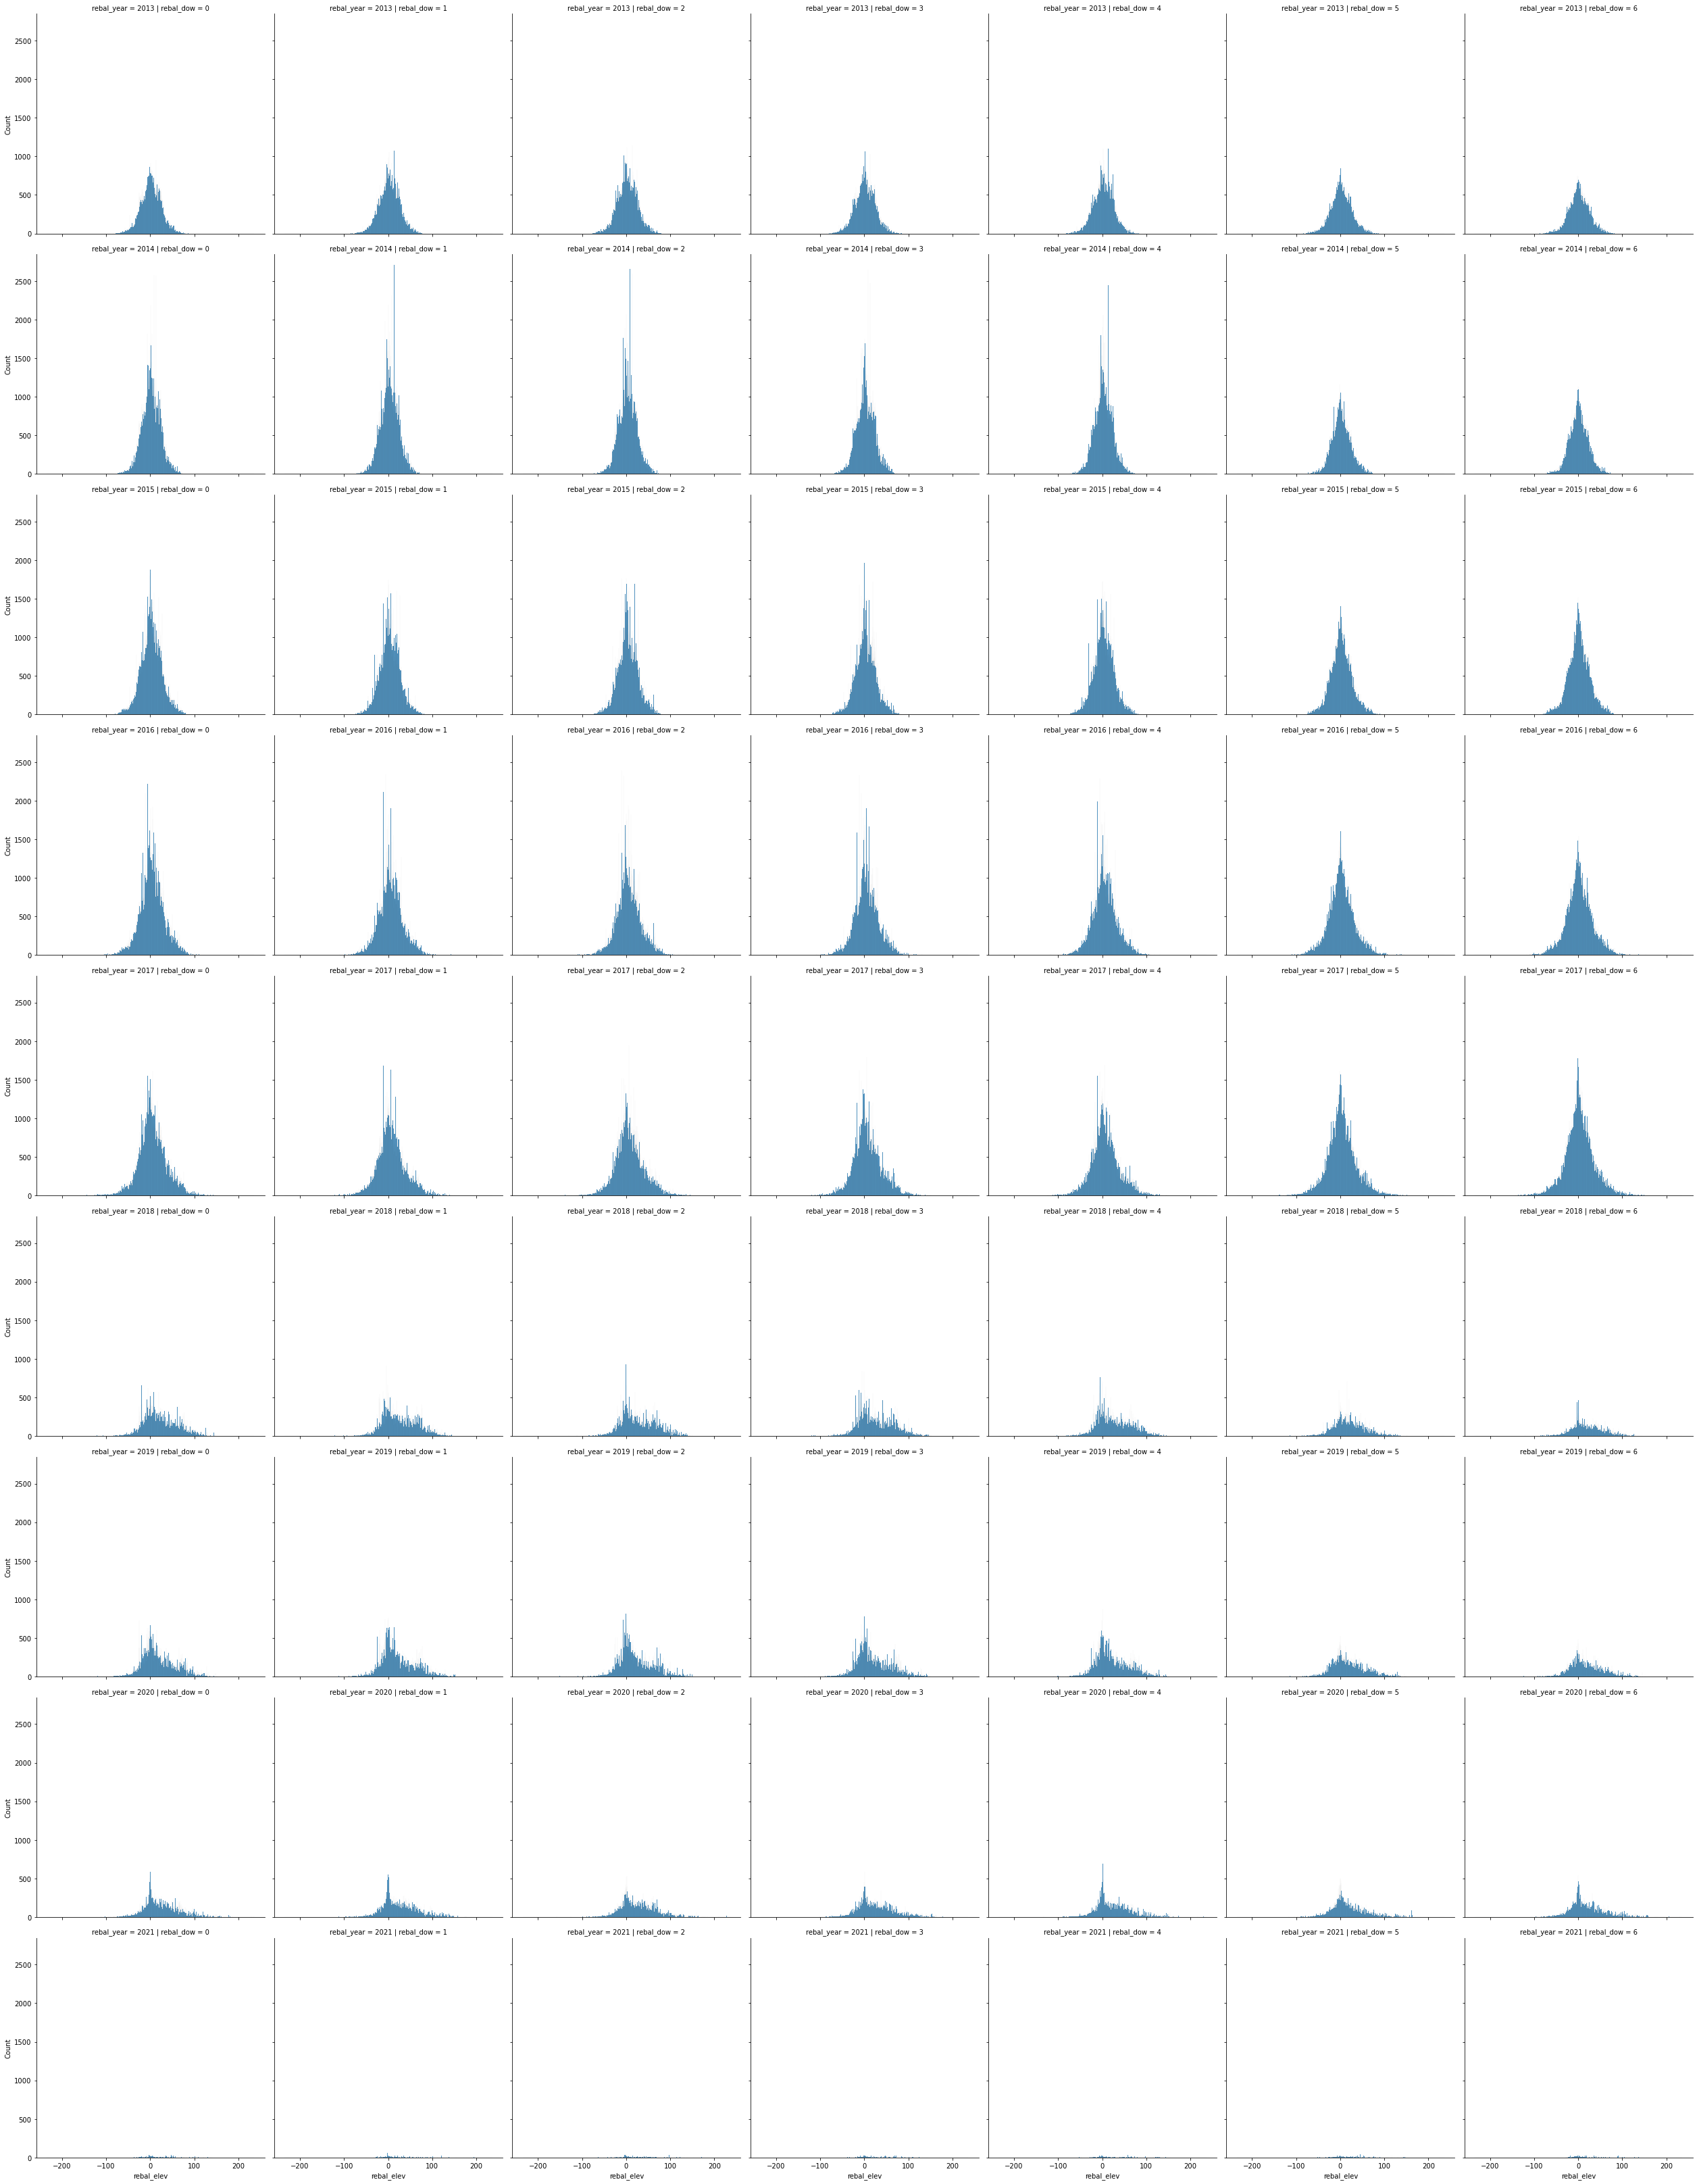

In [ ]:
# change in elevation for a given rebalance - faceted by year/month
sns.displot(
    data=rebal, x="rebal_elev_change", row="rebal_year", col="rebal_dow", kind="hist"
)

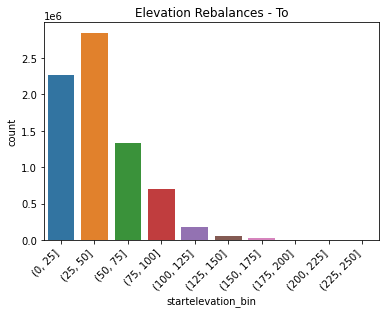

In [ ]:
# rebalances to elevation (binned)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=rebal.startelevation_bin)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - To")
plt.show()

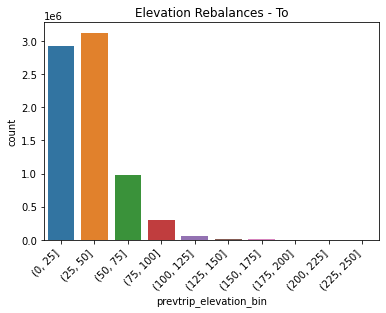

In [ ]:
# rebalances from elevation (binned)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=rebal.prevtrip_elevation_bin)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - To")
plt.show()

/tmp/ipykernel_1665/2509270379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['dir'] = 'To'
/tmp/ipykernel_1665/2509270379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.rename(columns={'startelevation_bin':'elevation'},inplace=True)
/tmp/ipykernel_1665/2509270379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

[Text(0.5, 1.0, 'Elevation Rebalances - Overall')]

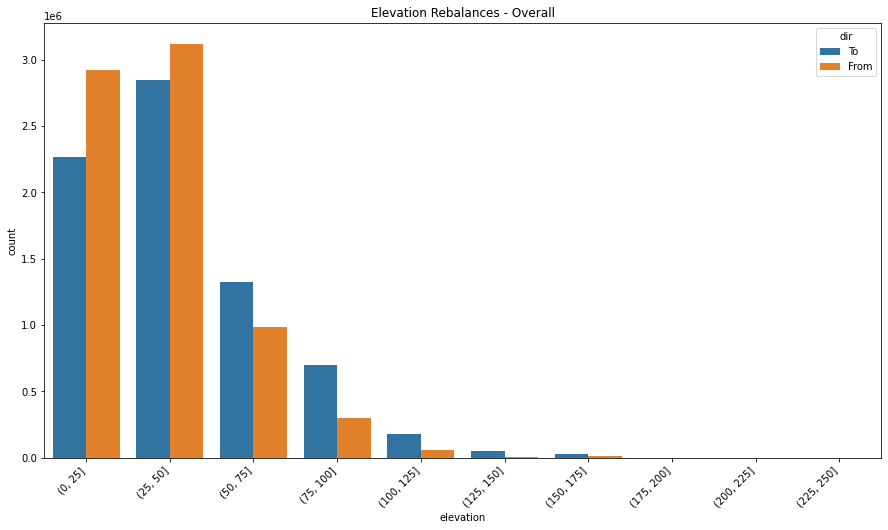

In [ ]:
# rebalances to & from (binned)
t = rebal[["startelevation_bin"]]
t["dir"] = "To"
t.rename(columns={"startelevation_bin": "elevation"}, inplace=True)
f = rebal[["prevtrip_elevation_bin"]]
f["dir"] = "From"
f.rename(columns={"prevtrip_elevation_bin": "elevation"}, inplace=True)
g = pd.concat([t, f], axis=0)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=g.elevation, hue=g.dir)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - Overall")

## Capacity TODO

## Boro & Neigborhood TODO

## Station
No faceting performed, is possible if desired

### Indidual Station Analysis

In [ ]:
rebal.prevtrip_elevation_ft.value_counts().sort_index()

-inf            194
 0.540039       239
 0.839844      1823
 0.870117      1529
 0.990234       171
               ... 
 191.125000      25
 193.625000      15
 197.125000      27
 199.125000      17
 242.625000      37
Name: prevtrip_elevation_ft, Length: 1117, dtype: int64

In [ ]:
g.prevtrip_elevation_ft.value_counts()

 27.468750    10792
-inf           8094
 47.437500     5396
 38.906250     5396
 60.375000     5396
              ...  
 12.187500     1349
 35.656250     1349
 19.281250     1349
 9.359375      1349
 58.062500     1349
Name: prevtrip_elevation_ft, Length: 1094, dtype: int64

In [ ]:
g.startelevation_ft.value_counts()

 27.468750    10792
-inf           9443
 38.281250     5396
 60.375000     5396
 38.906250     5396
              ...  
 18.203125     1349
 41.125000     1349
 68.750000     1349
 18.500000     1349
 47.875000     1349
Name: startelevation_ft, Length: 1092, dtype: int64

In [ ]:
g.loc[g.rebal_elev_change > 300][
    "rebal_count"
].value_counts()  # = sorted(set(g.rebal_elev_change))[1] #set elevation change = inf to max value

0      8010
1        27
3         6
2         6
120       1
7         1
4         1
Name: rebal_count, dtype: int64

In [ ]:
g.loc[g.rebal_elev_change < -300]["rebal_count"]

0     9383
1       15
35       1
6        1
2        1
Name: rebal_count, dtype: int64

In [ ]:
g.loc[g.rebal_elev_change > 300]

,startstationname,prevtrip_endstationname,rebal_count,startelevation_ft,prevtrip_elevation_ft,rebal_elev_change,rebal_route
11521,PABT Valet,NYCBS Depot BAL - DYR,120,30.40625,-inf,inf,PABT Valet to NYCBS Depot BAL - DYR
138929,Central Park S & 6 Ave,NYCBS Depot BAL - DYR,7,52.81250,-inf,inf,Central Park S & 6 Ave to NYCBS Depot BAL - DYR
169695,8 Ave & W 31 St,NYCBS Depot BAL - DYR,4,33.93750,-inf,inf,8 Ave & W 31 St to NYCBS Depot BAL - DYR
199106,Grand Army Plaza & Central Park S,NYCBS Depot BAL - DYR,3,50.43750,-inf,inf,Grand Army Plaza & Central Park S to NYCBS Dep...
199267,Broadway & W 24 St,NYCBS Depot BAL - DYR,3,39.93750,-inf,inf,Broadway & W 24 St to NYCBS Depot BAL - DYR
...,...,...,...,...,...,...,...
1818765,E 147 St & Bergen Ave,LPI Facility,0,27.46875,-inf,inf,E 147 St & Bergen Ave to LPI Facility
1819113,E 144 St & Brook Ave,LPI Facility,0,27.46875,-inf,inf,E 144 St & Brook Ave to LPI Facility
1819127,E 144 St & Brook Ave,NYCBS Depot BAL - DYR,0,27.46875,-inf,inf,E 144 St & Brook Ave to NYCBS Depot BAL - DYR
1819128,E 144 St & Brook Ave,NYCBS Depot - STY - Valet Scan,0,27.46875,-inf,inf,E 144 St & Brook Ave to NYCBS Depot - STY - Va...


In [ ]:
bins = range()

### Pairwise Station Analysis

In [ ]:
# group by pairs and count number per pair
g = (
    rebal.groupby(["startstationname", "prevtrip_endstationname"])[["bikeid"]]
    .count()
    .reset_index()
    .sort_values(by="bikeid", ascending=False)
)
g.rename(columns={"bikeid": "rebal_count"}, inplace=True)

# add elevation change column, round for easier plotting
g = g.merge(
    rebal[["startelevation_ft", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_elevation_ft", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
g["rebal_elev_change"] = g.startelevation_ft - g.prevtrip_elevation_ft
g.drop(columns=["startelevation_ft", "prevtrip_elevation_ft"], inplace=True)
g.rebal_elev_change = g.rebal_elev_change.round()

# a very small number of rows contain elevations that are +/- inf, change to 0 and ignore
g.loc[g.rebal_elev_change < -300, "rebal_elev_change"] = 0
g.loc[g.rebal_elev_change > 300, "rebal_elev_change"] = 0

# create a single string for rebalance route
g["rebal_route"] = (
    g.startstationname.astype("str") + " to " + g.prevtrip_endstationname.astype("str")
)

g[:20]

In [ ]:
g.loc[g.startstationname == "E 14 St & Avenue B"]

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,14813,-10.859375,E 14 St & Avenue B to E 7 St & Avenue A
9,E 14 St & Avenue B,E 20 St & FDR Drive,5708,5.804688,E 14 St & Avenue B to E 20 St & FDR Drive
27,E 14 St & Avenue B,E 10 St & Avenue A,3132,-5.906250,E 14 St & Avenue B to E 10 St & Avenue A
64,E 14 St & Avenue B,E 9 St & Avenue C,2286,1.195312,E 14 St & Avenue B to E 9 St & Avenue C
191,E 14 St & Avenue B,Pearl St & Hanover Square,1127,-1.703125,E 14 St & Avenue B to Pearl St & Hanover Square
...,...,...,...,...,...
1812726,E 14 St & Avenue B,Grand Concourse & E 171 St,0,-99.312500,E 14 St & Avenue B to Grand Concourse & E 171 St
1812727,E 14 St & Avenue B,Grand Concourse & E 167 St,0,-101.125000,E 14 St & Avenue B to Grand Concourse & E 167 St
1812728,E 14 St & Avenue B,Grand Concourse & E 166 St,0,-84.687500,E 14 St & Avenue B to Grand Concourse & E 166 St
1812729,E 14 St & Avenue B,Grand Concourse & E 164 St,0,-72.187500,E 14 St & Avenue B to Grand Concourse & E 164 St


In [ ]:
g.loc[g.prevtrip_endstationname == "E 14 St & Avenue B"]

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_route
2,E 7 St & Avenue A,E 14 St & Avenue B,7871,10.859375,E 7 St & Avenue A to E 14 St & Avenue B
18,E 20 St & FDR Drive,E 14 St & Avenue B,3764,-5.804688,E 20 St & FDR Drive to E 14 St & Avenue B
40,E 10 St & Avenue A,E 14 St & Avenue B,2778,5.906250,E 10 St & Avenue A to E 14 St & Avenue B
176,E 13 St & Avenue A,E 14 St & Avenue B,1194,5.039062,E 13 St & Avenue A to E 14 St & Avenue B
193,E 9 St & Avenue C,E 14 St & Avenue B,1125,-1.195312,E 9 St & Avenue C to E 14 St & Avenue B
...,...,...,...,...,...
1813813,E 149 St & Eagle Ave,E 14 St & Avenue B,0,20.359375,E 149 St & Eagle Ave to E 14 St & Avenue B
1816444,E 149 St & Jackson Ave,E 14 St & Avenue B,0,27.671875,E 149 St & Jackson Ave to E 14 St & Avenue B
1817080,E 144 St & Brook Ave,E 14 St & Avenue B,0,17.515625,E 144 St & Brook Ave to E 14 St & Avenue B
1817826,E 142 St & 3 Ave,E 14 St & Avenue B,0,19.531250,E 142 St & 3 Ave to E 14 St & Avenue B


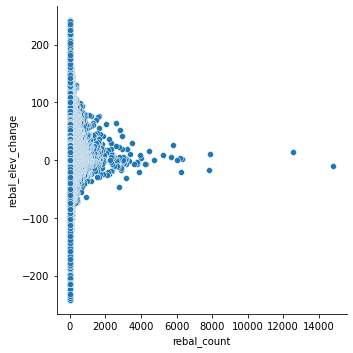

In [ ]:
# pairwise elevation change rebalances
sns.relplot(x=g.rebal_count, y=g.rebal_elev_change)

[Text(0.5, 1.0, 'Most Frequent Rebalance Routes'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of Bikes Rebalanced')]

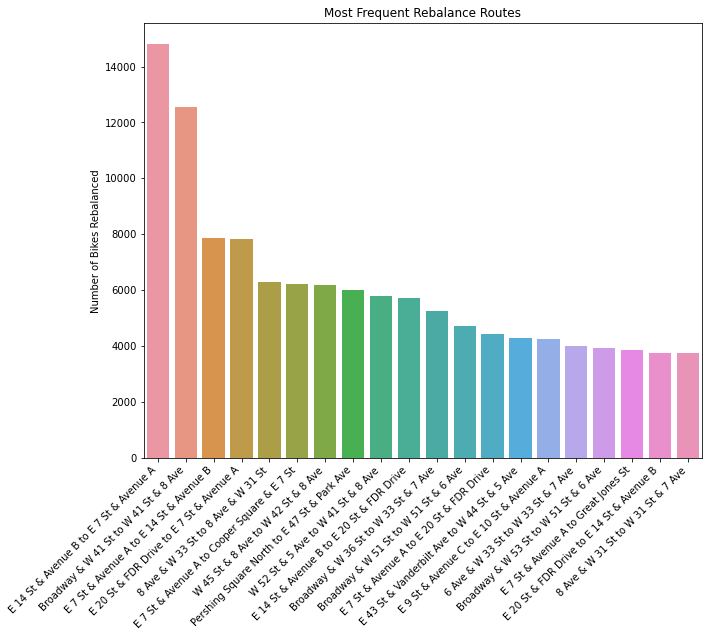

In [ ]:
# plot most frequent rebalance routes, ordered by count
plt.figure(figsize=(10, 8))
x = sns.barplot(y=g.rebal_count, x=g.rebal_route[:20])
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    title="Most Frequent Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)

In [ ]:
# plot most frequent rebalance routes, ordered by count
plt.figure(figsize=(10, 8))
x = sns.barplot(y=g.rebal_count, x=g.rebal_route[:20], order=g.rebal_elev_change)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    title="Most Frequent Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)

KeyboardInterrupt: 

## Geo Analysis
CAUTION - data has many null values (neighborhood in particular)

In [ ]:
# distribution of stations per neighborhood and boro
sns.histplot(locations.neighborhood.value_counts())

In [ ]:
plt.figure(figsize=(15, 8))
x = sns.countplot(
    x=rebal.neighborhood, order=rebal.neighborhood.value_counts().index[:20]
)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Count of Stations per neighborhood [top 20]")

AttributeError: 'DataFrame' object has no attribute 'neighborhood'

<Figure size 1080x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 8))
x = sns.countplot(x=locations.boro, order=locations.boro.value_counts().index)
# x.set_xticklabels(x.get_xticklabels(),rotation=45,horizontalalignment='right')
x.set(title="Count of Stations per boro")

# Rebalancing Analysis

In [ ]:
print(rides.shape)
print(rebal.shape)
print("The ratio of rebalances to rides in 2019 is: ", rebal.shape[0] / rides.shape[0])

## Rebalance by Station (to and from)

In [ ]:
# plot top20 rebalances
rebalout = (
    rebal["endstationname"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Station", "endstationname": "Count_Out"})[:20]
)
rebalin = (
    rebal["startstationname"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Station", "startstationname": "Count_In"})[:20]
)

plt.figure(figsize=(10, 8))
plt.title("Citi Bike Rebalancing [2019] From Stations")
sns.barplot(y=rebalout.Station, x=rebalout.Count_Out, orient="h")

plt.figure(figsize=(10, 8))
plt.title("Citi Bike Rebalancing [2019] To Stations")
sns.barplot(y=rebalin.Station, x=rebalin.Count_In, orient="h")